
def foo():
    a = 1
    a = a + 1
    return a

def main():
    import pdb; pdb.set_trace()
    return foo()

main()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
%matplotlib inline

from astropy import constants as const
from astropy.modeling import models, fitting

import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import scipy 
import scipy.signal as sig
from scipy.signal import medfilt
import scipy.optimize as op
import transit
import re

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Peak Detection

In [2]:
#Credits: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
    
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', 
                 kpsh=False, valley=False, show=False, ax=None):
    
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3: return np.array([], dtype=int)
    if valley: x = -x
    
    dx = x[1:] - x[:-1] # find indices of all peaks
    indnan = np.where(np.isnan(x))[0] # handle NaN's

    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
        
    ine, ire, ife = np.array([[], [], []], dtype=int)
    
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size: x[indnan] = np.nan
        if valley: x = -x
        plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [3]:
def plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function."""
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(x, '.', lw=1)
    if ind.size:
        label = r'valley' if valley else 'peak'
        label = label + 's' if ind.size > 1 else label

        ax.plot(ind, x[ind], '.', mfc=None, mec='r', mew=2, ms=7,
                label='%d %s' % (ind.size, label))
        
        ax.legend(loc = 'best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel(r'Position in the array', fontsize=14)
        ax.set_ylabel(r'Amplitude', fontsize=14)
        mode = r'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

In [21]:
filename = 'KID5972334.txt'
target_id = int(re.findall(r'\d+', filename)[0])

complete_sample = pd.read_csv('all_targets_P15to15point5.csv', sep=',', comment='#')
for row in complete_sample.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    if kepid == target_id:
        rs = getattr(row, "koi_srad") #solar radii
        rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
        rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
        smass = getattr(row, "koi_smass") #solar mass
        smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
        smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
        rp = getattr(row, "koi_prad") # in Earth radii
        rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
        srho = getattr(row, "koi_srho")  #g/cm3
        slogg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
        sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
        sma_solarRad = sma*215
        P = getattr(row, "koi_period") # Orbital Period [days]
        depth = getattr(row, "koi_depth") #parts per million
        b = getattr(row, "koi_impact")
        u1 = getattr(row, "koi_ldm_coeff1");
        u2 = getattr(row, "koi_ldm_coeff2")
        num_planets = getattr(row, "koi_count")
        inc = getattr(row,"koi_incl") #in degrees
        dor = getattr(row,"koi_dor") #Planet-Star Distance over Star Radius
        
print('rho={0:0.3f}, logg={1:0.3f} [log10(cm/s**2)], a={2:0.3f} [AU]'.format(srho, slogg,sma))

rho=1.851, logg=4.484 [log10(cm/s**2)], a=0.116 [AU]


864303


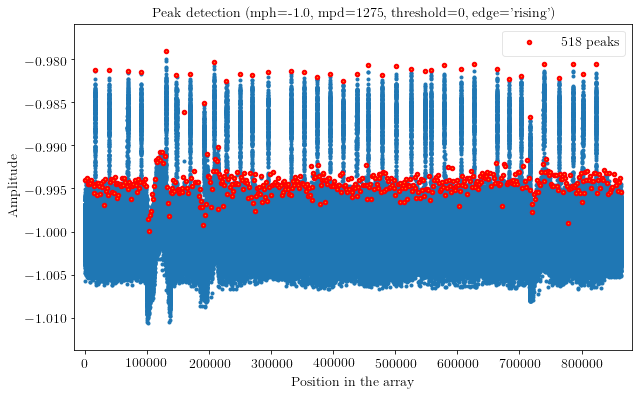

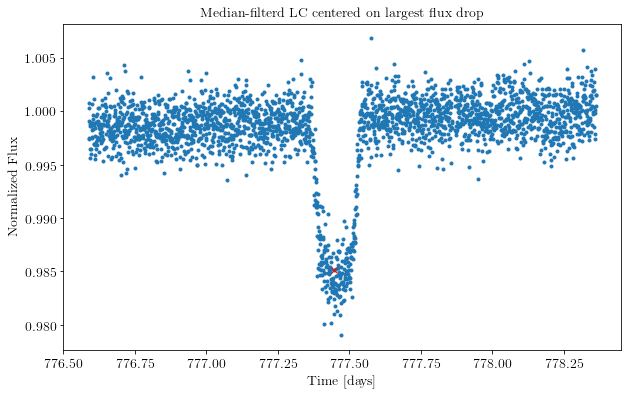

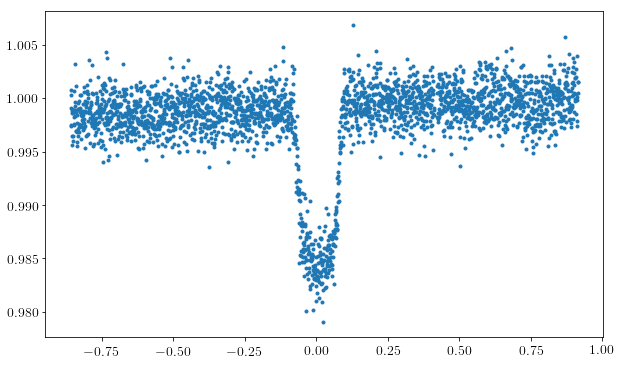

In [22]:
#KID5792202 = 5 planets

df = pd.read_csv(filename,sep='\t',index_col=None)
df.columns = ["time","flux","flux_err"]
x = df["time"]; y = df["flux"]; yerr = df["flux_err"]
print(len(x))

total_days = x.iloc[-1]-x.iloc[0]
one_day = int(len(x)/total_days) # len(x)/total_days corresponds to 1 day 

ind = detect_peaks(y*-1, mph=-1., mpd=one_day, show=True) #mpd: detect peaks that are at least separated by min peak distance (in number of data)
flux_peaks = y[ind]
time_max_peak = (flux_peaks).idxmin(axis=None, skipna=True)
dist_from_transit = int(one_day/1.)

#y = sig.medfilt(y,13)

newX = (x[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values
newY = (y[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values
newY_err = (yerr[time_max_peak-dist_from_transit:time_max_peak+dist_from_transit]).values

time_max_peak = np.argmin(sig.medfilt(newY,13))
tc = newX[time_max_peak]

plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".",tc, newY[time_max_peak],'xr'); 
plt.title('Median-filterd LC centered on largest flux drop')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")

# Subtract time offset
newX-=tc
plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".") 
np.savetxt('example_foldedLC.txt',  np.transpose([newX, newY]), fmt='%.3f', delimiter=' ')

# Occultquad (Mandel & Agol 2002)

In [6]:
from numpy import size,zeros,where,arccos, sqrt, pi, log

# Computes Hasting's polynomial approximation for the complete
# elliptic integral of the first (ek) and second (kk) kind
def ellke(k):
    m1=1.-k**2
    logm1 = log(m1)

    a1=0.44325141463
    a2=0.06260601220
    a3=0.04757383546
    a4=0.01736506451
    b1=0.24998368310
    b2=0.09200180037
    b3=0.04069697526
    b4=0.00526449639
    ee1=1.+m1*(a1+m1*(a2+m1*(a3+m1*a4)))
    ee2=m1*(b1+m1*(b2+m1*(b3+m1*b4)))*(-logm1)
    ek = ee1+ee2
        
    a0=1.38629436112
    a1=0.09666344259
    a2=0.03590092383
    a3=0.03742563713
    a4=0.01451196212
    b0=0.5
    b1=0.12498593597
    b2=0.06880248576
    b3=0.03328355346
    b4=0.00441787012
    ek1=a0+m1*(a1+m1*(a2+m1*(a3+m1*a4)))
    ek2=(b0+m1*(b1+m1*(b2+m1*(b3+m1*b4))))*logm1
    kk = ek1-ek2
    
    return [ek,kk]

# Computes the complete elliptical integral of the third kind using
# the algorithm of Bulirsch (1965):
def ellpic_bulirsch(n,k):
    kc=sqrt(1.-k**2); p=n+1.
    if(min(p) < 0.):
        print('Negative p')
    m0=1.; c=1.; p=sqrt(p); d=1./p; e=kc
    while 1:
        f = c; c = d/p+c; g = e/p; d = 2.*(f*g+d)
        p = g + p; g = m0; m0 = kc + m0
        if max(abs(1.-kc/g)) > 1.e-8:
            kc = 2*sqrt(e); e=kc*m0
        else:
            return 0.5*pi*(c*m0+d)/(m0*(m0+p))

#   Python translation of IDL code.
#   This routine computes the lightcurve for occultation of a
#   quadratically limb-darkened source without microlensing.  Please
#   cite Mandel & Agol (2002) and Eastman & Agol (2008) if you make use
#   of this routine in your research.  Please report errors or bugs to
#   jdeast@astronomy.ohio-state.edu
def occultquad(z,u1,u2,p0):

    nz = size(z)
    lambdad = zeros(nz)
    etad = zeros(nz)
    lambdae = zeros(nz)
    omega=1.-u1/3.-u2/6.

    ## tolerance for double precision equalities
    ## special case integrations
    tol = 1e-14

    p = abs(p0)
    
    z = where(abs(p-z) < tol,p,z)
    z = where(abs((p-1)-z) < tol,p-1.,z)
    z = where(abs((1-p)-z) < tol,1.-p,z)
    z = where(z < tol,0.,z)
               
    x1=(p-z)**2.
    x2=(p+z)**2.
    x3=p**2.-z**2.
    
    ## trivial case of no planet
    if p <= 0.:
        muo1 = zeros(nz) + 1. 
        mu0  = zeros(nz) + 1.
        return [muo1,mu0]

    ## Case 1 - the star is unocculted:
    ## only consider points with z lt 1+p
    notusedyet = where( z < (1. + p) )
    notusedyet = notusedyet[0]
    if size(notusedyet) == 0:
        muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*(lambdad+2./3.*(p > z))+ \
                  u2*etad)/omega
        mu0=1.-lambdae
        return [muo1,mu0]

    # Case 11 - the  source is completely occulted:
    if p >= 1.:
        occulted = where(z[notusedyet] <= p-1.)#,complement=notused2)
        if size(occulted) != 0:
            ndxuse = notusedyet[occulted]
            etad[ndxuse] = 0.5 # corrected typo in paper
            lambdae[ndxuse] = 1.
            # lambdad = 0 already
            notused2 = where(z[notusedyet] > p-1)
            if size(notused2) == 0:
                muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*(lambdad+2./3.* \
                                                 (p > z))+u2*etad)/omega
                mu0=1.-lambdae
                return [muo1,mu0]
            notusedyet = notusedyet[notused2]
                
    # Case 2, 7, 8 - ingress/egress (uniform disk only)
    inegressuni = where((z[notusedyet] >= abs(1.-p)) & (z[notusedyet] < 1.+p))
    if size(inegressuni) != 0:
        ndxuse = notusedyet[inegressuni]
        tmp = (1.-p**2.+z[ndxuse]**2.)/2./z[ndxuse]
        tmp = where(tmp > 1.,1.,tmp)
        tmp = where(tmp < -1.,-1.,tmp)
        kap1 = arccos(tmp)
        tmp = (p**2.+z[ndxuse]**2-1.)/2./p/z[ndxuse]
        tmp = where(tmp > 1.,1.,tmp)
        tmp = where(tmp < -1.,-1.,tmp)
        kap0 = arccos(tmp)
        tmp = 4.*z[ndxuse]**2-(1.+z[ndxuse]**2-p**2)**2
        tmp = where(tmp < 0,0,tmp)
        lambdae[ndxuse] = (p**2*kap0+kap1 - 0.5*sqrt(tmp))/pi
        # eta_1
        etad[ndxuse] = 1./2./pi*(kap1+p**2*(p**2+2.*z[ndxuse]**2)*kap0- \
           (1.+5.*p**2+z[ndxuse]**2)/4.*sqrt((1.-x1[ndxuse])*(x2[ndxuse]-1.)))
    
    # Case 5, 6, 7 - the edge of planet lies at origin of star
    ocltor = where(z[notusedyet] == p)#, complement=notused3)
    t = where(z[notusedyet] == p)
    if size(ocltor) != 0:
        ndxuse = notusedyet[ocltor] 
        if p < 0.5:
            # Case 5
            q=2.*p  # corrected typo in paper (2k -> 2p)
            Ek,Kk = ellke(q)
            # lambda_4
            lambdad[ndxuse] = 1./3.+2./9./pi*(4.*(2.*p**2-1.)*Ek+\
                                              (1.-4.*p**2)*Kk)
            # eta_2
            etad[ndxuse] = p**2/2.*(p**2+2.*z[ndxuse]**2)        
            lambdae[ndxuse] = p**2 # uniform disk
        elif p > 0.5:
            # Case 7
            q=0.5/p # corrected typo in paper (1/2k -> 1/2p)
            Ek,Kk = ellke(q)
            # lambda_3
            lambdad[ndxuse] = 1./3.+16.*p/9./pi*(2.*p**2-1.)*Ek-\
                              (32.*p**4-20.*p**2+3.)/9./pi/p*Kk
            # etad = eta_1 already
        else:
            # Case 6
            lambdad[ndxuse] = 1./3.-4./pi/9.
            etad[ndxuse] = 3./32.
        notused3 = where(z[notusedyet] != p)
        if size(notused3) == 0:
            muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*\
                      (lambdad+2./3.*(p > z))+u2*etad)/omega
            mu0=1.-lambdae
            return [muo1,mu0]
        notusedyet = notusedyet[notused3]

    # Case 2, Case 8 - ingress/egress (with limb darkening)
    inegress = where( ((z[notusedyet] > 0.5+abs(p-0.5)) & \
                       (z[notusedyet] < 1.+p))  | \
                      ( (p > 0.5) & (z[notusedyet] > abs(1.-p)) & \
                        (z[notusedyet] < p)) )#, complement=notused4)
    if size(inegress) != 0:

        ndxuse = notusedyet[inegress]
        q=sqrt((1.-x1[ndxuse])/(x2[ndxuse]-x1[ndxuse]))
        Ek,Kk = ellke(q)
        n=1./x1[ndxuse]-1.

        # lambda_1:
        lambdad[ndxuse]=2./9./pi/sqrt(x2[ndxuse]-x1[ndxuse])*\
                         (((1.-x2[ndxuse])*(2.*x2[ndxuse]+x1[ndxuse]-3.)-\
                           3.*x3[ndxuse]*(x2[ndxuse]-2.))*Kk+(x2[ndxuse]-\
                           x1[ndxuse])*(z[ndxuse]**2+7.*p**2-4.)*Ek-\
                          3.*x3[ndxuse]/x1[ndxuse]*ellpic_bulirsch(n,q))

        notused4 = where( ( (z[notusedyet] <= 0.5+abs(p-0.5)) | \
                            (z[notusedyet] >= 1.+p) ) & ( (p <= 0.5) | \
                            (z[notusedyet] <= abs(1.-p)) | \
                            (z[notusedyet] >= p) ))
        if size(notused4) == 0:
            muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*(lambdad+2./3.*\
                                                     (p > z))+u2*etad)/omega
            mu0=1.-lambdae
            return [muo1,mu0]
        notusedyet = notusedyet[notused4]

    # Case 3, 4, 9, 10 - planet completely inside star
    if p < 1.:
        inside = where(z[notusedyet] <= (1.-p))#, complement=notused5)
        if size(inside) != 0:
            ndxuse = notusedyet[inside]

            ## eta_2
            etad[ndxuse] = p**2/2.*(p**2+2.*z[ndxuse]**2)

            ## uniform disk
            lambdae[ndxuse] = p**2

            ## Case 4 - edge of planet hits edge of star
            edge = where(z[ndxuse] == 1.-p)#, complement=notused6)
            if size(edge[0]) != 0:
                ## lambda_5
                lambdad[ndxuse[edge]] = 2./3./pi*arccos(1.-2.*p)-\
                                      4./9./pi*sqrt(p*(1.-p))*(3.+2.*p-8.*p**2)
                if p > 0.5:
                    lambdad[ndxuse[edge]] -= 2./3.
                notused6 = where(z[ndxuse] != 1.-p)
                if size(notused6) == 0:
                    muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*\
                              (lambdad+2./3.*(p > z))+u2*etad)/omega
                    mu0=1.-lambdae
                    return [muo1,mu0]
                ndxuse = ndxuse[notused6[0]]

            ## Case 10 - origin of planet hits origin of star
            origin = where(z[ndxuse] == 0)#, complement=notused7)
            if size(origin) != 0:
                ## lambda_6
                lambdad[ndxuse[origin]] = -2./3.*(1.-p**2)**1.5
                notused7 = where(z[ndxuse] != 0)
                if size(notused7) == 0:
                    muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*\
                              (lambdad+2./3.*(p > z))+u2*etad)/omega
                    mu0=1.-lambdae
                    return [muo1,mu0]
                ndxuse = ndxuse[notused7[0]]
   
            q=sqrt((x2[ndxuse]-x1[ndxuse])/(1.-x1[ndxuse]))
            n=x2[ndxuse]/x1[ndxuse]-1.
            Ek,Kk = ellke(q)    

            ## Case 3, Case 9 - anywhere in between
            ## lambda_2
            lambdad[ndxuse] = 2./9./pi/sqrt(1.-x1[ndxuse])*\
                              ((1.-5.*z[ndxuse]**2+p**2+x3[ndxuse]**2)*Kk+\
                               (1.-x1[ndxuse])*(z[ndxuse]**2+7.*p**2-4.)*Ek-\
                               3.*x3[ndxuse]/x1[ndxuse]*ellpic_bulirsch(n,q))

        ## if there are still unused elements, there's a bug in the code
        ## (please report it)
        notused5 = where(z[notusedyet] > (1.-p))
        if notused5[0] != 0:
            print("ERROR: the following values of z didn't fit into a case:")
            return [-1,-1]

        muo1 =1.-((1.-u1-2.*u2)*lambdae+(u1+2.*u2)*(lambdad+2./3.*(p > z))+\
                  u2*etad)/omega
        mu0=1.-lambdae
        return [muo1,mu0]

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


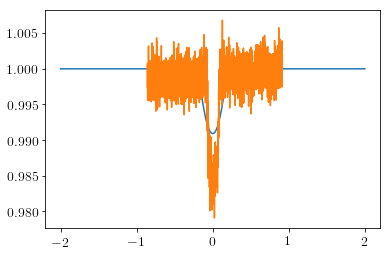

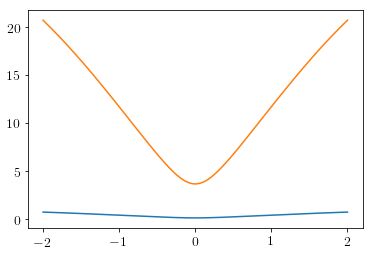

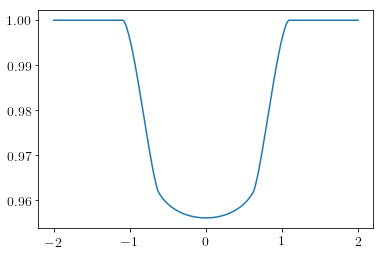

In [7]:
"""#Inputs: 
(1) z: 
    -> normalized separation of the host star and plan (z) (http://www.astro.utoronto.ca/~astrolab/files/AST326_Lab5_2018.pdf )
    -> sequence of positional offset values || 
    -> z = d/r∗ (d is the projected separation of the planetary and stellar centers). It can be calculated with: (http://othes.univie.ac.at/7459/1/2009-11-10_0404319.pdf)
        z(t) = a/Rs*[(sinωt)^2 +(cosi·cosωt)^2]^(1/2)

    Note that z(t) never assumes negative values and only decreases to zero for central transits. 

(2) p: ratio of the radius of the planet and the radius of the star (Rp/R*)
(3) c1, c2: LD coefficients 

In total 7 variables, (a/R∗, rp/R∗, inc, tc, ω = 2π/P, u1, u2) are needed for the model.
"""
period_grid = np.linspace(13.0,700.,1000)

def zt(a,Rs,P,i,t):
    omega = 2*np.pi/P
    return a/Rs*(np.sin(omega*t)**2+(np.cos(i)*np.cos(omega*t)))**(1/2)

plt.figure()
omega = 2*np.pi/P
t = np.linspace(-2,2,1000)
z = zt(sma_solarRad,rs,P,inc*np.pi/180,t)
p0 = rp_solarRad/rs
F1, Funi = occultquad(z/4, u1, u2, p0)
plt.plot(t, F1, label='teoric')
plt.plot(newX, newY, label = 'real')

plt.figure()
plt.plot(t,(np.sin(omega*t)**2+(np.cos(inc*np.pi/180)*np.cos(omega*t)))**(1/2))
plt.plot(t,z)

def chi(theta,x,y):
    a, rs, P, i, u1, u2, rp = theta
    z = zt(a,rs,P,i,x)
    p0 = rp/rs
    F1, Funi = occultquad(z, u1, u2, p0)
    return np.mean((F1-y)**2)


p, b = 0.1, 0.5
x = np.linspace(-2,2,300)
z3 = np.sqrt(x**2 + b**2)
F1, Funi = occultquad(z3, 0.3, 0.2, 0.2)
plt.figure()
plt.plot(x,F1)

In [ ]:
init = np.array([sma_solarRad/4,rs,15,inc*np.pi/180,u1,u2,rp_solarRad])
res = op.minimize(chi,init,args=(newX,newY))

In [ ]:
z = zt(*res['x'][:4],newX)
f1, _ = occultquad(z,*res['x'][4:-1],res['x'][-1]/res['x'][1])
plt.plot(newX,f1,newX,newY)

In [ ]:
def ln_prior(theta):
    a, rs, P, i, u1, u2, rp = theta
    b = a*np.cos(i)/rs
    sum_u = u1+u2
    if a<0 or rs<0 or rp<0 or P<0 or b<0 or b>1 or sum_u<0 or sum_u>1:
        return -np.inf
    return 0.0

def lnprob(theta,*args):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return -chi(theta,*args)+lp

# MCMC parameters
ndim, nwalkers = len(init), 60
pos = [res['x'] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_curved = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (newX, newY))
sampler_curved.run_mcmc(pos, 500, progress=True);

In [ ]:
samples = sampler_curved.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples,show_titles=True)

In [ ]:
truths = np.percentile(samples,50,axis=0)
z = zt(*truths[:4],newX)
f1, _ = occultquad(z,*truths[4:-1],truths[-1]/truths[1])
plt.plot(newX,f1,newX,newY)

# Transit Routine (DFM)

A Python library for generating light curves of transiting planets.

In [184]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = sigma = an additional white noise term
    theta[3] = u1 + u2 = sum of LD coefficients
    theta[4] = pmass = the mass of the star (controlled via gaussian prior)
    theta[5] = pradius = the radius of the star (controlled via gaussian prior)
    theta[6] = f0 = the out of eclipse flux
    theta[7] = orbital period
    """
    pdepth, pb, sigma, sumLD, pmass, pradius, f0, pperiod = theta 
    
    #Note: pmass and prad (stellar mass and radius) controlled via 
    # gaussian prior -> By letting M* and R* be free parameters in 
    # our transit model, we are allowing the mean stellar density to fluctuate. 
    
    ecc, mass, masserr, radius, radiuserr, diffLD, tKep, tc = allfixed
    
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=tc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

def lnprior(theta):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, sumLD, pmass, pradius, f0, pperiod = theta
    if ((0.3 < sumLD < 1.0) and (0 <= pb < 1.0) and (0 <= sigma) and 
    (pradius > 0) and (pdepth > 0.0) and (pmass > 0.0) and (13 <=pperiod < 500)):
        return 0.0
    return -np.inf    
    
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, diffLD, tKep, tc = allfixed
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [159]:
sc = 58.0  #sc = 58 sec
tKep = sc * (1. / 60.) * (1. / 60.) * (1. / 24.)  # sc in days

period_guess = 13.5
ecc = 0.0
t_conj = 0.0
diffLD = u1 - u2
#sigma_guess = np.std(newY_err)

allfixed = [ecc, smass, smass_err, rs, rs_err, diffLD, tKep, t_conj]
depth_guess = 1 - newY.min()
#rp = np.sqrt(depth_guess)*rs
#mp = 2.69*(rp)**(0.93)

nll = lambda *args: -lnprob(*args)

result0 = op.minimize(
    nll, [1.2 * depth_guess, 0.5, 0.0, u1 + u2, smass, rs, 1.0, period_guess],
    args=(newX, sig.medfilt(newY, 13), 0.0, allfixed),
    options={
        'maxiter': 1e5,
        'disp': True
    },
    method='Nelder-Mead')

depth0_ml, b0_ml, sigma0_ml, sumLD0_ml, mass0_ml, radius0_ml, f00_ml, period0_ml = result0[
    "x"]

#Update LD
u1_0_ml = 0.5 * (sumLD0_ml + diffLD)
u2_0_ml = sumLD0_ml - u1_0_ml
result0["x"][3] = sumLD0_ml

print("\t\t Period (fit 0): {:0.6f} days".format(period0_ml))

result1 = op.minimize(
    nll,
    result0['x'],
    args=(newX, newY, 0.0, allfixed),
    options={
        'maxiter': 1e5,
        'disp': True
    },
    method='Nelder-Mead')

depth1_ml, b1_ml, sigma1_ml, sumLD1_ml, mass1_ml,\
radius1_ml, f01_ml, period1_ml  = result1["x"]

#Update LD
u1_1_ml = 0.5 * (sumLD1_ml + diffLD)
u2_1_ml = sumLD1_ml - u1_1_ml
result1["x"][3] = sumLD1_ml

print("\t\t Period (fit 1): {:0.6f} days".format(period1_ml))

result2 = op.minimize(
    nll,
    result1["x"],
    args=(newX, newY, newY_err, allfixed),
    options={
        'maxiter': 1e5,
        'disp': True
    },
    method='Nelder-Mead')

depth2_ml, b2_ml, sigma2_ml, sumLD2_ml, mass2_ml, \
radius2_ml, f0_2_ml, period2_ml  = result2["x"]

u1_2_ml = 0.5 * (sumLD2_ml + diffLD)
u2_2_ml = sumLD2_ml - u1_2_ml

# Compute the light curve integrated over a Kepler short cadence  exposure time.
s = transit.System(
    transit.Central(
        mu1=u1_2_ml, mu2=u2_2_ml, mass=mass2_ml, radius=radius2_ml))

body = transit.Body(
    radius=np.sqrt(depth2_ml) * radius2_ml,
    period=period2_ml,
    t0=t_conj,
    b=b2_ml,
    e=ecc)

s.add_body(body)
t = np.arange(-1, 1, tKep * 0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f - 1.0 + f0_2_ml

print("\t\t Period (fit 3): {:0.6f} days".format(period2_ml))
print("Depth {:0.3f}".format(depth2_ml))

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -16684.653274
         Iterations: 624
         Function evaluations: 951
		 Period (fit 0): 14.823639 days
Optimization terminated successfully.
         Current function value: -14792.318968
         Iterations: 964
         Function evaluations: 1447
		 Period (fit 1): 13.000010 days
Optimization terminated successfully.
         Current function value: 5.409672
         Iterations: 829
         Function evaluations: 1290
		 Period (fit 3): 14.688583 days
Depth 0.011


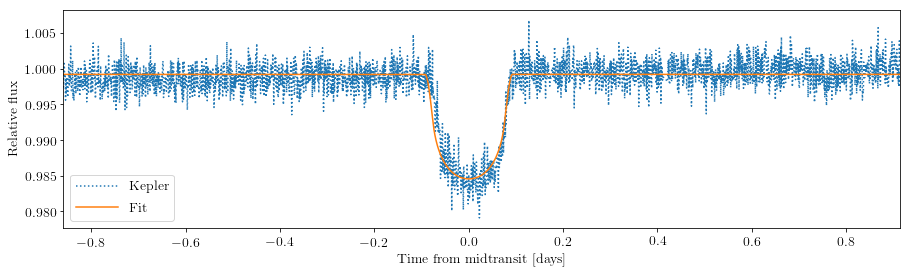

In [160]:
# Plot the results
fig = plt.figure(figsize=(15,4))
plt.plot(newX,newY, linestyle = 'dotted', label = 'Kepler')
plt.plot(t, f, label = 'Fit')
plt.xlabel('Time from midtransit [days]')
plt.ylabel('Relative flux')
#plt.ylim([1-depth_ml*1.5, depth_ml*0.5+1]) 
plt.xlim([min(newX),max(newX)]) 
plt.legend()

In [161]:
print(result2['x'])

print("Some results from minimization:")
print("Period [days]: \n\t Fit): {0:0.4f}, \n\tTrue):{1:0.4f}".format(period2_ml,P))
print("Depth [ppm]: \n\t Fit): {0:0.4f}, \n\tTrue):{1:0.4f}".format(depth2_ml,depth/1e6))
print("Stellar mass [Msun]: \n\tFit): {0:0.4f}, \n\tTrue):{1:0.4f}".format(mass2_ml,smass))
print("Stellar radius [Rsun]: \n\tFit): {0:0.4f}, \n\tTrue):{1:0.4f}".format(radius2_ml,rs))

[1.09744759e-02 2.44042408e-01 1.00105512e-05 9.99999999e-01
 8.74000046e-01 8.86999310e-01 9.99217161e-01 1.46885832e+01]
Some results from minimization:
Period [days]: 
	 Fit): 14.6886, 
	True):15.3588
Depth [ppm]: 
	 Fit): 0.0110, 
	True):0.0146
Stellar mass [Msun]: 
	Fit): 0.8740, 
	True):0.8740
Stellar radius [Rsun]: 
	Fit): 0.8870, 
	True):0.8870


In [178]:
ndim, nwalkers = 8, 100

evaluate_res = result2["x"]

p0 = [evaluate_res*(1+1e-4*np.random.randn(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(newX, newY, newY_err, allfixed))
print("Running burn-in")
pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
sampler.reset()
print("Running production")
sampler.run_mcmc(p0, 3000, rstate0 = state, progress=True);

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
  0%|          | 0/200 [00:00<?, ?it/s]

Running burn-in


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/emcee-3.0.0.dev0-py3.6.egg/emcee/moves/red_blue.py:96: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - log_probs[j]
  0%|          | 0/3000 [00:00<?, ?it/s]

Running production


100%|██████████| 3000/3000 [13:59<00:00,  3.68it/s]


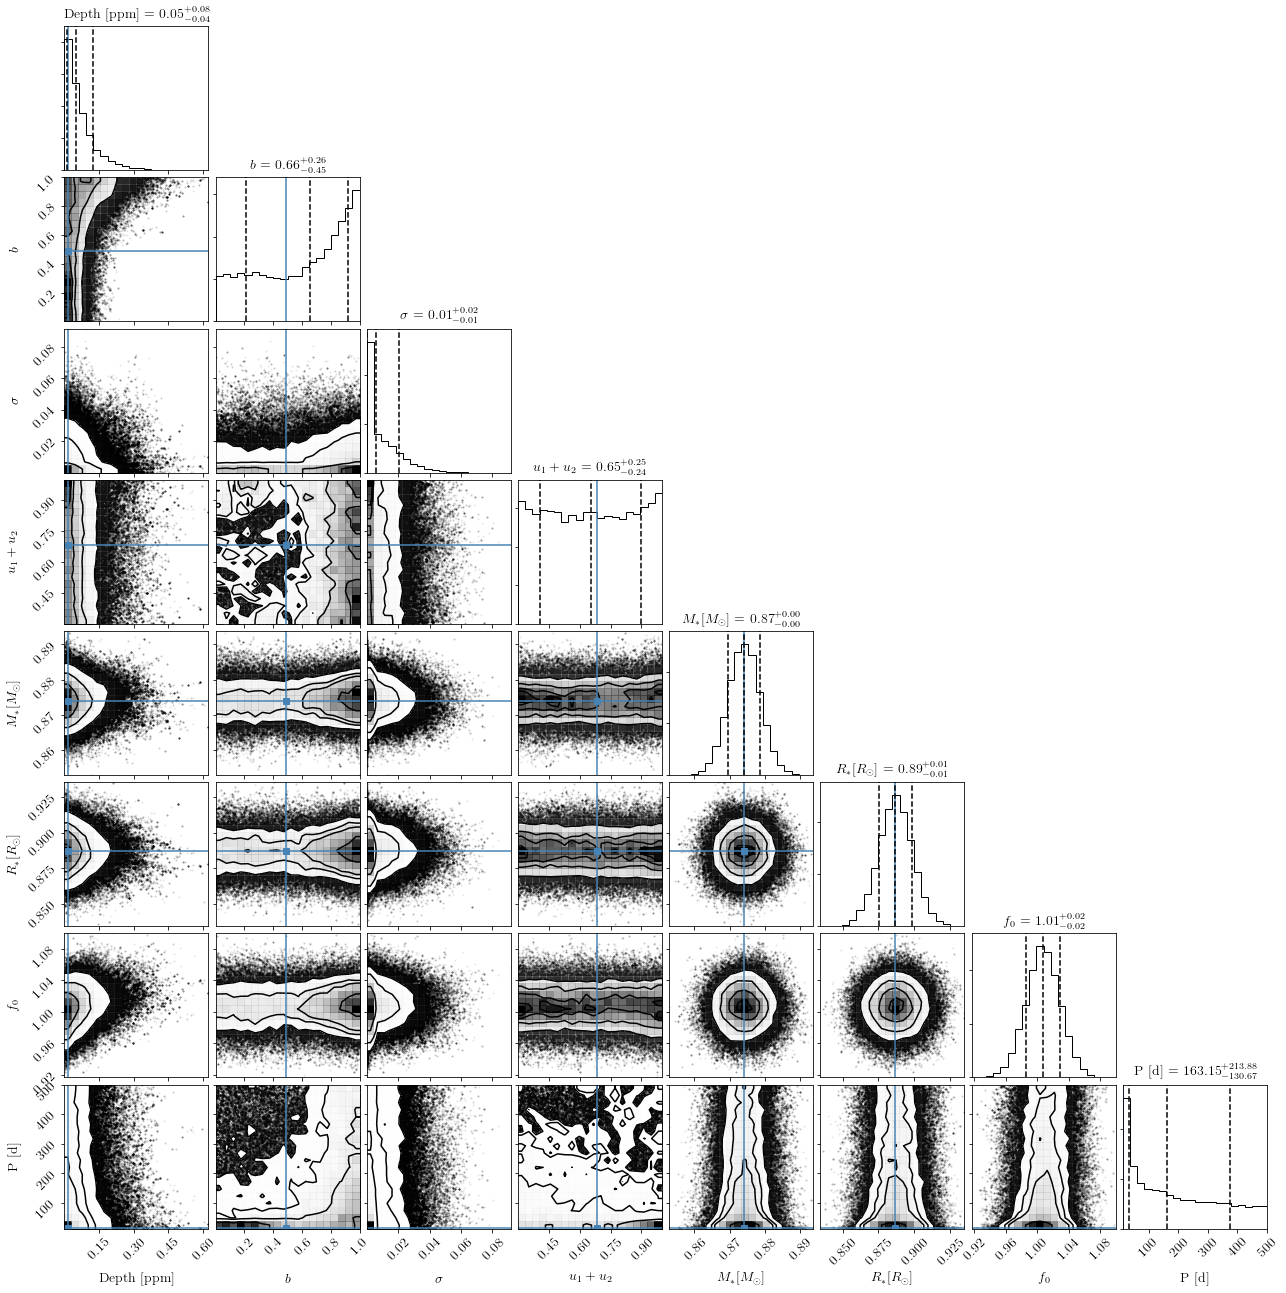

In [179]:
#perform burn-in
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
np.savetxt('mcmc_samples.txt', samples)

true_params = [depth / 1e6, b, None, u1 + u2, smass, rs, None, P]

fig = corner.corner(samples, labels=["Depth [ppm]", r"$b$", r"$\sigma$", r'$u_{1}+u_{2}$',
        r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', r'$f_{0}$', 'P [d]'],
    quantiles=[0.16, 0.5, 0.84], truths=true_params, show_titles=True,
    title_args={"fontsize": 12}, plot_contours=True)

#show_titles = Title showing the 0.5 quantile, with the upper and lower errors
#supplied by the quantiles argument.

sampler.acceptance_fraction;
#http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html

In [185]:
print([depth/1e6, b,None,u1+u2,smass,rs,None,P])

[0.014638, 0.487, None, 0.6853, 0.874, 0.887, None, 15.358767770999998]


In [186]:
np.savetxt('mcmc_samples.txt',samples)
np.savetxt('mcmc_results.txt',result2["x"])

In [187]:
G = 6.6730e-11

samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 5] #in earth rad

P1 = period2_ml*24.0*3600.0 #in sec
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc, sigma_mcmc, \
sumLD_mcmc, smass_mcmc, rs_mcmc, \
f0_mcmc, period_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                           zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius is:

In [212]:
print("\nDepth:\n\tTrue = {:0.3f}".format(depth/1e6))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
print("\tChi2 Fit = {0:0.3f}".format(result2['x'][0]))

print("\nImpact parameter:\n\tTrue = {:0.3f}".format(b))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("\tChi2 Fit = {0:0.3f}".format(result2['x'][1]))

print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(rp))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))

print("\nStellar mass [Msun]:\n\tTrue = {:0.3f}".format(smass))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))
print("\tChi2 Fit = {0:0.3f}".format(result2['x'][4]))

print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(rs))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
print("\tChi2 Fit = {0:0.3f}".format(result2['x'][5]))

print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(P))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
print("\tChi2 Fit = {0:0.3f}".format(result2['x'][7]))

print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.3f}".format(1/dor))
print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))


Depth:
	True = 0.015
	MCMC Fit = 0.049 (+0.077,-0.037)
	Chi2 Fit = 0.011

Impact parameter:
	True = 0.487
	MCMC Fit = 0.659 (+0.264,-0.450)
	Chi2 Fit = 0.244

Planet radius [REarth]:
	True = 10.890
	MCMC Fit = 21.540 (+12.836,-10.662)

Stellar mass [Msun]:
	True = 0.874
	MCMC Fit = 0.874 (+0.005,-0.005)
	Chi2 Fit = 0.874

Stellar radius [Rsun]:
	True = 0.887
	MCMC Fit = 0.887 (+0.012,-0.012)
	Chi2 Fit = 0.887

Period [d]:
	True = 15.359
	MCMC Fit = 163.154 (+214.950,-130.921)
	Chi2 Fit = 14.689

Inverse of scaled semi-major axis:
	True = 0.035
	MCMC Fit = 0.042 (+0.001,-0.001)


## Questions
-> radius and mass-->Yonsei-Yale Isochrones? or can use kepler database?

# Rough estimations

In [ ]:
def get_keyTimes(times, pre, post, offset, drop, ind_maxPeak):
    y1 = np.abs(pre-offset+0.35*drop)
    y2 = np.abs(pre-offset+0.65*drop)
    y3 = np.abs(post-offset+0.65*drop)
    y4 = np.abs(post-offset+0.35*drop)
    
    margin = 20
    res1 = times[np.argmin(y1)]
    res2 = times[np.argmin(y2)+margin]
    res3 = times[np.argmin(y3)+ind_maxPeak-margin]
    res4 = times[np.argmin(y4)+ind_maxPeak]
    
    return res1, res2, res3, res4

In [ ]:
baseline = np.median(newY)
delta = np.median(newY)-newY[time_max_peak]

pre_tr = newY[:time_max_peak]
post_tr = newY[time_max_peak:]

t1,t2,t3,t4 = get_keyTimes(newX, pre_tr, post_tr, baseline, delta, time_max_peak)

print("t1 = {0:0.2f} days | t2 = {1:0.2f} days | t3 = {2:0.2f} days | t4 = {3:0.2f}".format(t1,t2,t3,t4))

xposition = [t1,t2,t3,t4]
plt.figure(figsize=(10,6))
plt.plot(newX, newY, ".",tc, newY[time_max_peak],'o')
plt.ylabel("Flux"); plt.xlabel("Time [days]")
for xc in xposition: plt.axvline(x=xc, color='r', linestyle='dotted')

In [ ]:
tc = (((t3+t2)/2)+((t4+t1)/2))/2
width_trans = t3-t2
slope_trans = -delta/(t2-t1)
T = ((t4+t3)-(t2+t1))/2 #FWHM 
tau_avg = ((t2-t1)+(t4-t3))/2

print(tc,(t3+t2)/2, (t4+t1)/2)

In [ ]:
t_init = models.Trapezoid1D(amplitude=-delta, x_0=tc, width=width_trans, slope=slope_trans)
                           #fixed={'amplitude': True})
g_init = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
l_init = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 

fit_flux = fitting.LevMarLSQFitter()

t = fit_flux(t_init, newX, newY-baseline)
g = fit_flux(g_init, newX, newY-baseline)
l = fit_flux(l_init, newX, newY-baseline)

#Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, label='Trapezoid')
plt.plot(newX, g(newX)+baseline, label='Gaussian')
plt.plot(newX, l(newX)+baseline, label='Lorentz')
plt.ylabel("Normalized Flux"); plt.xlabel("Time [days]")
plt.legend()

In [ ]:
##THIS IS ONLY FOR TRAPEZOID MODEL
amp_fit, x0_fit, width_fit, slope_fit = t.parameters

delta_fit = amp_fit*-1
tc_fit = x0_fit

t1_fit = (delta_fit/slope_fit)+t2
t2_fit = (2.*tc_fit-width_fit)/2.
t3_fit = (2.*tc_fit+width_fit)/2.
t4_fit = 2*tc_fit-t1_fit

T_fit = ((t4_fit+t3_fit)-(t2_fit+t1_fit))/2 #FWHM 
tau_fit = ((t2_fit-t1_fit)+(t4_fit-t3_fit))/2

print("T = {0:0.2f} days\ntau = {1:0.2f} days\ndelta = {2:0.5f}\nt1 = {3:0.2f} , t2 = {4:0.2f},\\
t3 = {5:0.2f} , t4 = {6:0.2f} [days]".format(T_fit, tau_fit,
                                               delta_fit, t1_fit, t2_fit,
                                               t3_fit,t4_fit))


tfits_position = [t1_fit,t2_fit,t3_fit,t4_fit]
plt.plot(newX, newY, '.')
plt.plot(newX, t(newX)+baseline, '.k', label='Trapezoid')
plt.xlabel('Time [days]'); plt.ylabel('Normalized Flux')
for xc in tfits_position: plt.axvline(x=xc, color='m', linestyle='dotted')

In [ ]:
Q = 7.1
sigmaP_P = np.sqrt(1/Q**2 * (27*T_fit/2*tau_fit))
print(sigmaP_P)

In [ ]:
G = 6.676e-11  #Unit  = m3 / (kg s2)# Newton's constant in $R_\odot^3 M_\odot^{-1} {days}^{-2}$: G = 2945.4625385377644
srho_kgm3 = srho * 1000   #srho is originally given in g/cm3, but we convert it to kg/m3 

In [ ]:
b2_fit = 1-(T_fit*(np.sqrt(delta_fit))/tau_fit)
P_fit = (((G*np.pi**2)/3)*srho_kgm3*(T_fit*tau_fit*86400**2/np.sqrt(delta_fit))**(3/2))/86400#in days
sma_fit = slogg/4.*(T_fit*tau_fit/np.sqrt(delta_fit))

print("b ||\t Fitted: {1:0.3f}, Real: {0:0.3f} ".format(np.sqrt(b2_fit),b))
print("P ||\t Fitted: {0:0.3f}, Real: {1:0.3f} [days]".format(P_fit,P)) 
print("a ||\t Fitted: {0:0.3f}, Real: {1:0.3f} [AU]".format(sma,sma_fit))

## Data Folding

In [ ]:
def fold_data(t,f, tcfit, Pfit, Tfit):
    range_transit = Tfit/2 #[days]
    print("Period (fit): {0:0.3f} days, Transit range: {1:0.3f} days".format(Pfit,range_transit))
    x = (t - tcfit + range_transit*Pfit) % Pfit - range_transit*Pfit
    m = np.abs(x) < 0.5
    tfolded = x[m]
    ffolded = f[m]
    return tfolded, ffolded
    
newX_fold, newY_fold = fold_data(newX, newY, tc_fit, P_fit, T_fit)

plt.plot(newX_fold,newY_fold,'.')
plt.xlabel('Time [days]'); plt.ylabel('Normalized Flux')
plt.title('Folded LC')

In [ ]:
f0 = models.Linear1D(slope = 0.0, intercept = np.median(newY))
gau = models.Gaussian1D(amplitude=-delta, mean=tc, stddev=T)
loren = models.Lorentz1D(amplitude=-delta, x_0=tc, fwhm = T) 
trap = models.Trapezoid1D(amplitude=-delta, x_0=tc, width=t3-t2, slope=-delta/(t2-t1))

# Now to fit the data create a new superposition with initial guesses for the parameters:
LG_init = f0+gau
LL_init = f0+loren
LT_init = f0+trap

fit_flux = fitting.SLSQPLSQFitter()
LG_fit = fit_flux(LG_init, newX, newY);
LL_fit = fit_flux(LL_init, newX, newY);
LT_fit = fit_flux(LT_init, newX, newY);

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(newX, newY, '.')
plt.plot(newX, LG_fit(newX),label='Linear + Gaussian')
plt.plot(newX, LL_fit(newX),label='Linear + Lorentz')
plt.plot(newX, LT_fit(newX),label='Linear + Trapezoidal')
plt.legend(); plt.xlabel('Time [days]'); plt.ylabel('Flux')

In [ ]:
import emcee
import corner

def lnprior(theta, args):
    minT, maxT = args
    delta, tc, width, slope = theta
    if 0.0 < delta < 0.2 and  (minT < tc < maxT) and (0.0 < width < (maxT-minT)) and (-1<slope<0.0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr = None):
    minT = min(x)
    maxT = max(x)
    lp = lnprior(theta, (minT, maxT))
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)
    #return lnlike(theta, x, y, yerr)

def lnlike(theta, x, y, yerr = None):
    delta, tc, width, slope = theta
    model = models.Trapezoid1D(amplitude=-delta, x_0=tc, 
                               width=width, slope=slope)
    
    #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model(x))**2))

ndim, nwalkers = 4, 100
mc_guess = [delta, tc, t3-t2, -delta/(t2-t1)]

pos = [mc_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(newX, newY-np.median(newY)))

sampler.run_mcmc(pos, 500);

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

fig = corner.corner(samples, 
                    labels=["$delta$", "$tc$", "$width$", "$slope$"])

In [ ]:
import vespa
sample_res = vespa.transit_basic.traptransit_MCMC(newX, newY, dfs=1e-05,
                                     nwalkers=200, nburn=300, niter=1000, 
                                     threads=1, p0=[0.1, 0.1, 3, 0], return_sampler=True, maxslope=30)

In [ ]:
samples2 = sample_res.chain[:, 5:, :].reshape((-1, ndim))
fig = corner.corner(samples2)